Differences between three sample preps  
- Different proteins abundances
- Localisation distribution, where do the missing proteins come form?

In [2]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt
import random
import seaborn as sns

/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Cellular location

In [3]:
protein_dict = {}
datasets = ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']
names = ['evo96', 'proteochip_D0', 'proteochip_PFA']


# Iterate over each dataset
for name, dataset in zip(names, datasets):
    df = pd.read_csv(dataset, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    proteins = list(set(proteins))
    protein_dict[name] = proteins

In [ ]:
from bioservices import UniProt
u = UniProt(verbose=False)

cellular_location = {}
import requests
from tqdm import tqdm
all_method_locations = {}

for key, value in protein_dict.items():
    one_method_locations = []
    for identifier in tqdm(value):
        results = u.search(identifier,frmt="tsv", columns="cc_subcellular_location")
        if len(results) > len("Subcellular location [CC]"):
            results_split = results.split('SUBCELLULAR LOCATION: ')[1].split('}. ')
            for i in results_split:
                if "{ECO" in i:
                    one_method_locations.append(i.split(' {ECO')[0])
        all_method_locations[key] = one_method_locations


        

    

100%|██████████| 861/861 [02:44<00:00,  5.24it/s]


In [4]:
#save all_method_locations as a pickle
# import pickle
# with open('all_method_locations.pickle', 'wb') as handle:
#     pickle.dump(all_method_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

#load all_method_locations as a pickle
import pickle
with open('all_method_locations.pickle', 'rb') as handle:
    all_method_locations = pickle.load(handle)


In [38]:
def find_class(x):
    for c in classes:
        if c.lower() in x.lower():
            return c
    return x

classes = ['Cytoplasm', 'Nucleus', 'Membrane', 'Mitochondrion', 'Secreted', 'Endoplasmic reticulum', 'Synap', 'Golgi', 'Cell junction', 'Endosome', 'Chromosome', 'Lysosome', 'Cell projection']
#make one generic class based on the list, where substring is found in the index column

#make a dataframe with the classes, value_counts per key    
location_df = pd.DataFrame()
for key, value in all_method_locations.items():
    series = pd.Series(value)
    filtered_series = series[~series.str.startswith('Note')]
    location_df[key] = filtered_series.apply(find_class).value_counts()

In [39]:
#normalize for the amount of proteins in the sample
location_df['evo96_norm'] = location_df['evo96'] / len(protein_dict['evo96'])
location_df['proteochip_D0_norm'] = location_df['proteochip_D0'] / len(protein_dict['proteochip_D0'])
location_df['proteochip_PFA_norm'] = location_df['proteochip_PFA'] / len(protein_dict['proteochip_PFA'])


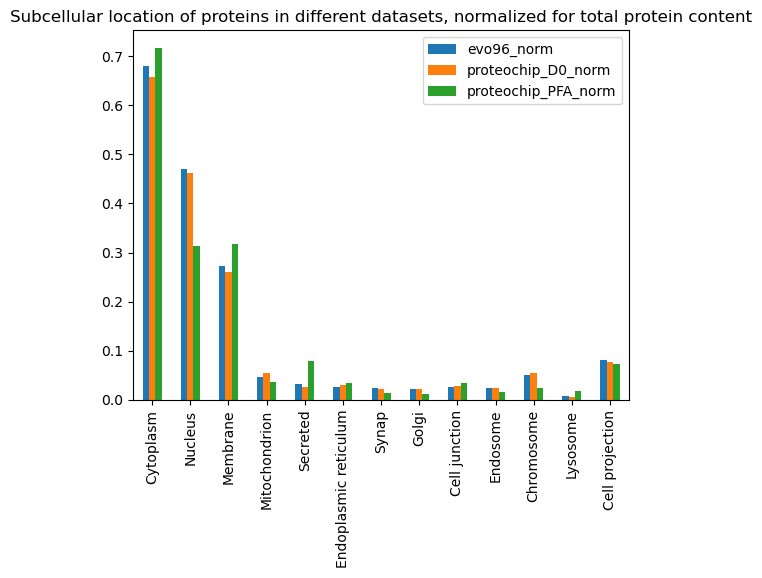

In [40]:
#make a barplot for each class in classes, plot the valou counts, group per column
fig, ax = plt.subplots()
subset = location_df.loc[classes]
subset[['evo96_norm', 'proteochip_D0_norm', 'proteochip_PFA_norm']].plot(kind='bar', ax=ax)
plt.title('Subcellular location of proteins in different datasets, normalized for total protein content')
plt.show()



### Abundance range

/tmp/ipykernel_5795/1720124242.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names)


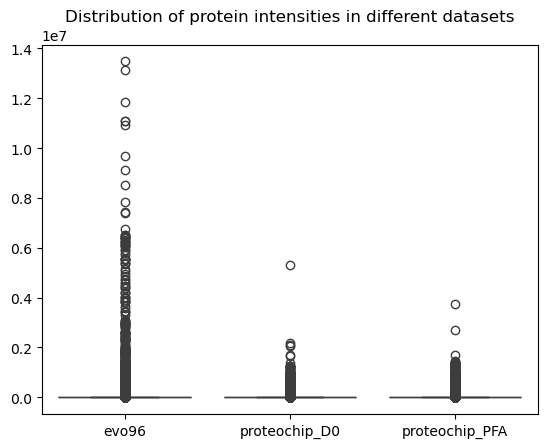

In [41]:
fig, ax = plt.subplots()

# Prepare a list to store all data for plotting
all_data = []
all_labels = []

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    df = pd.read_csv(dataset, sep='\t')
    df_values = df.iloc[:, 5:].values.flatten()
    #drop na from df_values
    df_values = df_values[~np.isnan(df_values)]
    all_data.append(df_values)
    all_labels.extend([name] * len(df_values))

# Create a boxplot for all datasets
sns.boxplot(data=all_data, ax=ax)
ax.set_xticklabels(names)
plt.title('Distribution of protein intensities in different datasets')
plt.show()

EVO96 seems to have the most information, but D0 has the most retina similarity

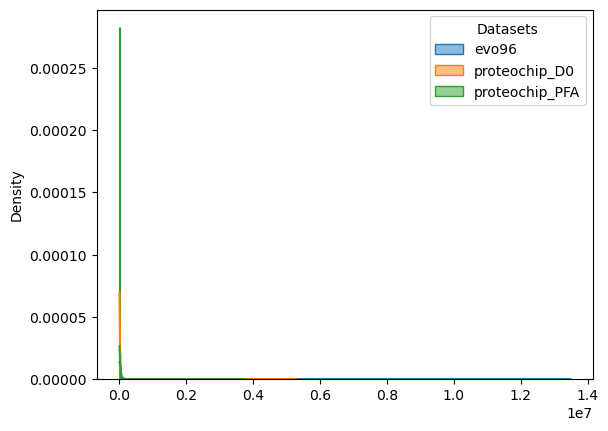

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots()

# Iterate over each dataset
for name, dataset in zip(names, datasets):
    df = pd.read_csv(dataset, sep='\t')
    df_values = df.iloc[:, 5:].values.flatten()
    # Create a histogram for each dataset
    sns.histplot(df_values, ax=ax, label=name, kde=True, element='step', stat='density')

# Add legend with dataset names
ax.legend(title='Datasets')

plt.show()

Proteins that are in D0 and not in PFA, in what abundance range do they fall?

In [43]:
protein_lists = []
for i in ['evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv', 'proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv']:    
    df = pd.read_csv(i, sep='\t')
    proteins = np.array(df[["Protein.Ids"]].values.tolist()).flatten()
    # if it contains ';' split it and take both
    proteins = [x.split(';') for x in proteins]
    proteins = [item for sublist in proteins for item in sublist]
    proteins = list(set(proteins))
    print(i, len(proteins))
    protein_lists.append(set(proteins))

evo96_report_organoids_culture_15042024_diann181.pg_matrix.tsv 2764
proteochip_D0_report_organoids_culture_15042024_diann181.pg_matrix.tsv 3951
proteochip_PFA_report_organoides_042024_fixes.pg_matrix.tsv 861


2764
3951
861


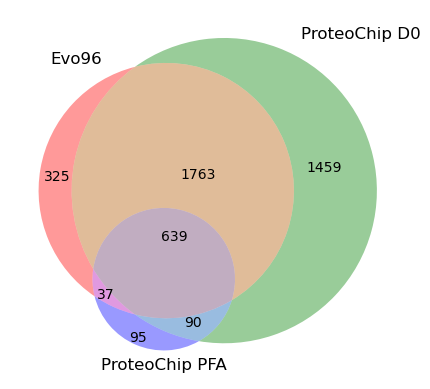

In [44]:
from matplotlib_venn import venn3
for i in protein_lists:
    print(len(i))
# Create the Venn diagram
venn3(protein_lists, ('Evo96', 'ProteoChip D0', 'ProteoChip PFA'))

In [45]:
unique_evo96 = protein_lists[0]- protein_lists[1]- protein_lists[2]
unique_proteochip_D0 = protein_lists[1] - protein_lists[0] - protein_lists[2]
unique_proteochip_PFA = protein_lists[2] - protein_lists[0] - protein_lists[1]

Proteins that are in the other methods but not in the PFA

/tmp/ipykernel_5795/1853175551.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


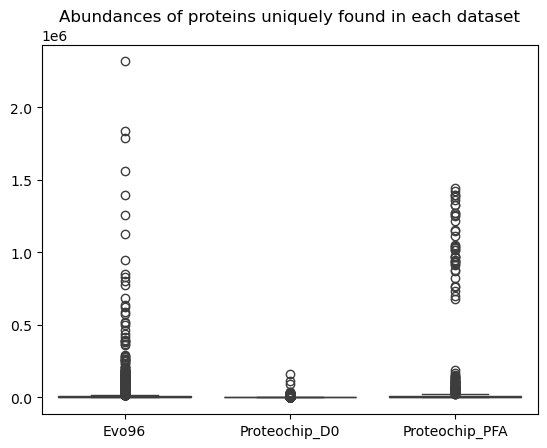

In [46]:
abundances_evo96 = []
abundances_proteochip_D0 = []
abundances_proteochip_PFA = []
results = [abundances_evo96, abundances_proteochip_D0, abundances_proteochip_PFA]
uniqueness = [unique_evo96, unique_proteochip_D0, unique_proteochip_PFA]
# Iterate over each dataset
for name, dataset, unique, resultje in zip(names, datasets, uniqueness, results):
    df = pd.read_csv(dataset, sep='\t')
    df = df[df["Protein.Ids"].isin(unique)]
    df_values = df.iloc[:, 5:].values.flatten()
    #drop na from df_values
    df_values = df_values[~np.isnan(df_values)]
    resultje.append(df_values)

# Flatten the data and prepare for plotting
flattened_data = [item for sublist in results for item in sublist]
labels = ['Evo96', 'Proteochip_D0', 'Proteochip_PFA']

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Create a grouped boxplot
sns.boxplot(data=flattened_data, ax=ax)
ax.set_xticklabels(labels)
plt.title('Abundances of proteins uniquely found in each dataset')
plt.show()

## Human subproteomes

Can this be due to cell damage and protein leakage that a different subset of the proteome leaks out?   
==> match to the secretome

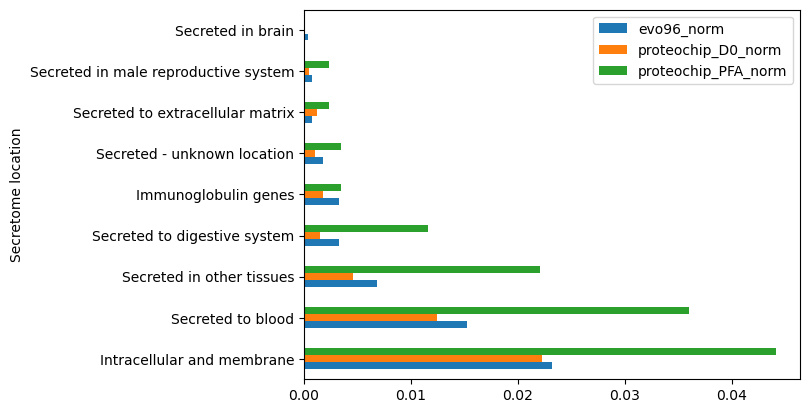

In [94]:
hpa_secreted = pd.read_csv('sa_location_Secreted.tsv', sep='\t')
hpa_secreted_uniprots = hpa_secreted['Uniprot'].values
secretome = pd.DataFrame()
for sublist, name in zip(protein_lists, names):
    detected = [x for x in sublist if x in hpa_secreted_uniprots]
    locations = []
    subset = hpa_secreted[hpa_secreted['Uniprot'].isin(detected)]['Secretome location'].value_counts()
    secretome[name] = subset
    secretome['evo96_norm'] = secretome['evo96'] / len(protein_dict['evo96'])
secretome['proteochip_D0_norm'] = secretome['proteochip_D0'] / len(protein_dict['proteochip_D0'])
secretome['proteochip_PFA_norm'] = secretome['proteochip_PFA'] / len(protein_dict['proteochip_PFA'])

#make a barplot for each class in classes, plot the valou counts, group per column
fig, ax = plt.subplots()
secretome[['evo96_norm', 'proteochip_D0_norm', 'proteochip_PFA_norm']].plot(kind='barh', ax=ax)

plt.show()



### Membrane proteome

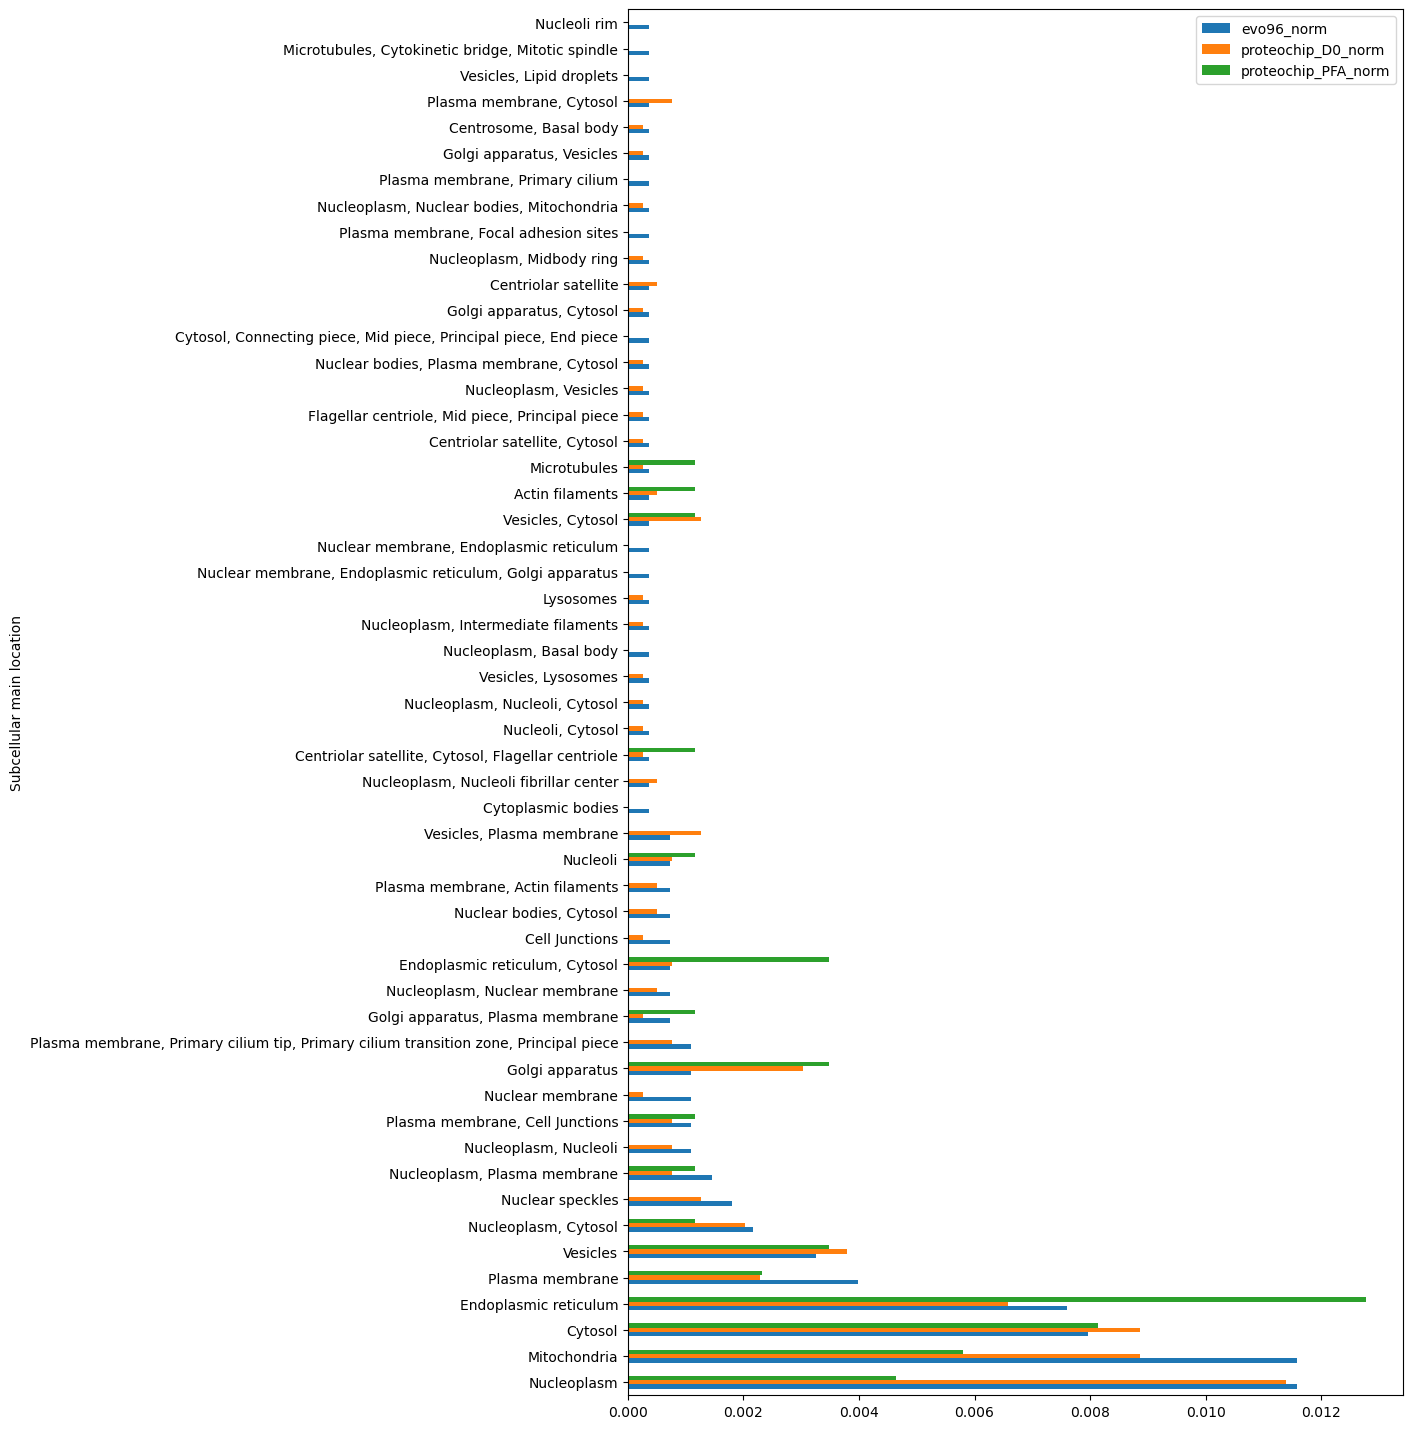

In [100]:
hpa_membrane = pd.read_csv('protein_class_Predicted.tsv', sep='\t')
hpa_membrane_uniprots = hpa_membrane['Uniprot'].values
membranome = pd.DataFrame()
for sublist, name in zip(protein_lists, names):
    detected = [x for x in sublist if x in hpa_membrane_uniprots]
    locations = []
    subset = hpa_membrane[hpa_membrane['Uniprot'].isin(detected)]['Subcellular main location'].value_counts()
    membranome[name] = subset
membranome['evo96_norm'] = membranome['evo96'] / len(protein_dict['evo96'])
membranome['proteochip_D0_norm'] = membranome['proteochip_D0'] / len(protein_dict['proteochip_D0'])
membranome['proteochip_PFA_norm'] = membranome['proteochip_PFA'] / len(protein_dict['proteochip_PFA'])

#make a barplot for each class in classes, plot the valou counts, group per column
fig, ax = plt.subplots(figsize=(10, 18))    
membranome[['evo96_norm', 'proteochip_D0_norm', 'proteochip_PFA_norm']].plot(kind='barh', ax=ax)

plt.show()



PFA looses Mitochondrial and nuclear proteins, but has more secreted/endoplasmic reticulum proteins (fixation of the ECM?)

### Regulatory proteome (TF)

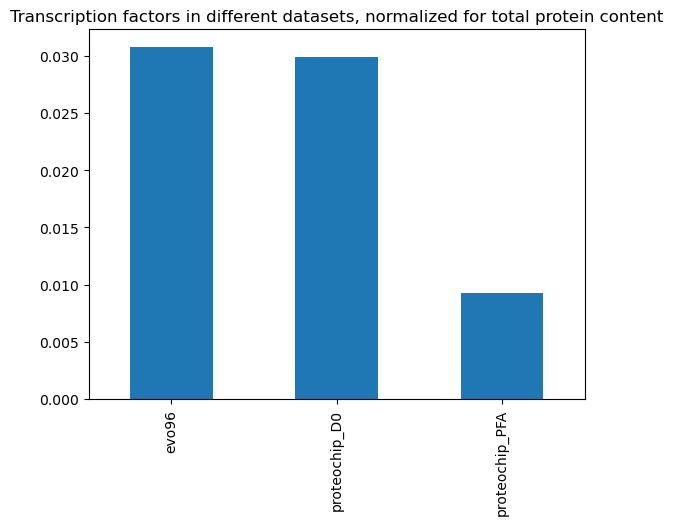

In [109]:
hpa_tf = pd.read_csv('protein_class_transcription.tsv', sep='\t')
hpa_tf_uniprots = hpa_tf['Uniprot'].values
tfome = {}
for sublist, name in zip(protein_lists, names):
    detected = [x for x in sublist if x in hpa_tf_uniprots]
    number_detected = len(detected)
    #just store the number of transcription factors
    tfome[name] = number_detected

tfome_norm = {}

for k,v in tfome.items():
    tfome_norm[k] = v / len(protein_dict[k])

#make a barplot for each class in classes, plot the valou counts, group per column
fig, ax = plt.subplots()
pd.Series(tfome_norm).plot(kind='bar', ax=ax)
plt.title('Transcription factors in different datasets, normalized for total protein content')
plt.show()

In [83]:
len(detected), name

(73, 'proteochip_PFA')